In [104]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [75]:
df = pd.read_csv('dataset/synthetic_logs.csv')
df.head()

,timestamp,source,log_message,target_label,complexity
0,6/27/2025 7:20,ModernCRM,nova.osapi_compute.wsgi.server [req-b9718cd8-f...,HTTP Status,bert
1,1/14/2025 23:07,ModernCRM,Email service experiencing issues with sending,Critical Error,bert
2,1/17/2025 1:29,AnalyticsEngine,Unauthorized access to data was attempted,Security Alert,bert
3,7/12/2025 0:24,ModernHR,nova.osapi_compute.wsgi.server [req-4895c258-b...,HTTP Status,bert
4,6/2/2025 18:25,BillingSystem,nova.osapi_compute.wsgi.server [req-ee8bc8ba-9...,HTTP Status,bert


In [76]:
df.source.unique()

array(['ModernCRM', 'AnalyticsEngine', 'ModernHR', 'BillingSystem',
       'ThirdPartyAPI', 'LegacyCRM'], dtype=object)

In [77]:
df.target_label.unique()

array(['HTTP Status', 'Critical Error', 'Security Alert', 'Error',
       'System Notification', 'Resource Usage', 'User Action',
       'Workflow Error', 'Deprecation Warning'], dtype=object)

In [78]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import DBSCAN

# Load the Sentence Transformer model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Generate embeddings for the log_message column
embeddings = model.encode(df['log_message'].tolist())
embeddings[:2]  # Display the first 5 embeddings

array([[-1.02939621e-01,  3.35459411e-02, -2.20260732e-02,
         1.55101740e-03, -9.86917876e-03, -1.78956270e-01,
        -6.34409785e-02, -6.01761639e-02,  2.81109158e-02,
         5.99620491e-02, -1.72618348e-02,  1.43363548e-03,
        -1.49560034e-01,  3.15287686e-03, -5.66030927e-02,
         2.71685235e-02, -1.49891041e-02, -3.54037657e-02,
        -3.62936445e-02, -1.45410765e-02, -5.61491773e-03,
         8.75539035e-02,  4.55120578e-02,  2.50963885e-02,
         1.00187510e-02,  1.24267349e-02, -1.39923573e-01,
         7.68696293e-02,  3.14095505e-02, -4.15247958e-03,
         4.36902344e-02,  1.71250012e-02, -8.00951198e-02,
         5.74006326e-02,  1.89091656e-02,  8.55262503e-02,
         3.96398641e-02, -1.34371817e-01, -1.44360063e-03,
         3.06704035e-03,  1.76854044e-01,  4.44885530e-03,
        -1.69274509e-02,  2.24266481e-02, -4.35049310e-02,
         6.09034160e-03, -9.98169929e-03, -6.23972900e-02,
         1.07372422e-02, -6.04895083e-03, -7.14660808e-0

In [79]:
# Perform clustering using DBSCAN
dbscan = DBSCAN(eps=0.2, min_samples=1, metric='cosine')
clusters = dbscan.fit_predict(embeddings)

# Add the cluster labels to the dataframe
df['cluster'] = clusters

# Display the first few rows with cluster labels
df[['source', 'log_message', 'cluster']].head()

,source,log_message,cluster
0,ModernCRM,nova.osapi_compute.wsgi.server [req-b9718cd8-f...,0
1,ModernCRM,Email service experiencing issues with sending,1
2,AnalyticsEngine,Unauthorized access to data was attempted,2
3,ModernHR,nova.osapi_compute.wsgi.server [req-4895c258-b...,0
4,BillingSystem,nova.osapi_compute.wsgi.server [req-ee8bc8ba-9...,0


In [80]:
df[df['cluster'] == 1].head()  # Display noise points (outliers)

,timestamp,source,log_message,target_label,complexity,cluster
1,1/14/2025 23:07,ModernCRM,Email service experiencing issues with sending,Critical Error,bert,1
10,8/9/2025 18:58,ModernCRM,Email server encountered a sending fault,Error,bert,1
217,1/22/2025 5:45,BillingSystem,Mail service encountered a delivery glitch,Error,bert,1
248,5/2/2025 23:04,ModernHR,Service disruption caused by email sending error,Critical Error,bert,1
265,3/30/2025 23:53,ModernCRM,Email system had a problem sending emails,Error,bert,1


In [81]:
# Count the number of records in each cluster
cluster_counts = df['cluster'].value_counts()

# Filter clusters with more than 10 records
large_clusters = cluster_counts[cluster_counts > 10].index

# Iterate through the filtered clusters and print 5 log messages
for cluster in large_clusters:
    print(f"Cluster {cluster}:")
    print(df[df['cluster'] == cluster]['log_message'].head(5).to_string(index=False))
    print("\n")

Cluster 0:
nova.osapi_compute.wsgi.server [req-b9718cd8-f6...
nova.osapi_compute.wsgi.server [req-4895c258-b2...
nova.osapi_compute.wsgi.server [req-ee8bc8ba-92...
nova.osapi_compute.wsgi.server [req-f0bffbc3-5a...
nova.osapi_compute.wsgi.server [req-2bf7cfee-a2...


Cluster 5:
nova.compute.claims [req-a07ac654-8e81-416d-bfb...
nova.compute.claims [req-d6986b54-3735-4a42-907...
nova.compute.claims [req-72b4858f-049e-49e1-b31...
nova.compute.claims [req-5c8f52bd-8e3c-41f0-95a...
nova.compute.claims [req-d38f479d-9bb9-4276-968...


Cluster 11:
User User685 logged out.
 User User395 logged in.
 User User225 logged in.
User User494 logged out.
 User User900 logged in.


Cluster 13:
Backup started at 2025-05-14 07:06:55.
Backup started at 2025-02-15 20:00:19.
  Backup ended at 2025-08-08 13:06:23.
Backup started at 2025-11-14 08:27:43.
Backup started at 2025-12-09 10:19:11.


Cluster 7:
Multiple bad login attempts detected on user 85...
Multiple login failures occurred on user 9052 a...
  U

In [82]:
import re

# Function to classify log messages based on regex patterns
def classify_with_regex(log_message):

    regex_patterns = {
        r"User User\d+ logged (in|out)." : "User Action", 
        r"Backup (started|ended) at .*" : "System Notification", 
        r"Backup completed successfully." : "System Notification", 
        r"System updated to version .*" : "System Notification", 
        r"File .* uploaded successfully by user .*" : "System Notification", 
        r"Disk cleanup completed successfully.": "System Notification",
        r"System reboot initiated by user .*": "System Notification", 
        r"Account with ID .* created by .*": "User Action"
    }

    for pattern, label in regex_patterns.items():
        if re.search(pattern, log_message, re.IGNORECASE):
            return label
    return None  # Default label if no pattern matches

In [83]:
classify_with_regex("System reboot initiated by User hamza")

'System Notification'

In [84]:
# Apply the classification function to the log_message column
df['regex_label'] = df['log_message'].apply(classify_with_regex)

# Display the first few rows with the classified labels
df[df.regex_label.notnull()].shape

(500, 7)

In [85]:
df_non_regex = df[df.regex_label.isnull()].copy()
df_non_regex.head()

,timestamp,source,log_message,target_label,complexity,cluster,regex_label
0,6/27/2025 7:20,ModernCRM,nova.osapi_compute.wsgi.server [req-b9718cd8-f...,HTTP Status,bert,0,None
1,1/14/2025 23:07,ModernCRM,Email service experiencing issues with sending,Critical Error,bert,1,None
2,1/17/2025 1:29,AnalyticsEngine,Unauthorized access to data was attempted,Security Alert,bert,2,None
3,7/12/2025 0:24,ModernHR,nova.osapi_compute.wsgi.server [req-4895c258-b...,HTTP Status,bert,0,None
4,6/2/2025 18:25,BillingSystem,nova.osapi_compute.wsgi.server [req-ee8bc8ba-9...,HTTP Status,bert,0,None


In [86]:
lessthen5 = df_non_regex['target_label'].value_counts()[df_non_regex['target_label'].value_counts() <= 5].index.tolist()
lessthen5

['Workflow Error', 'Deprecation Warning']

In [87]:
df_non_legacy = df_non_regex[df_non_regex.source != 'LegacyCRM']
df_non_legacy.source.unique()

array(['ModernCRM', 'AnalyticsEngine', 'ModernHR', 'BillingSystem',
       'ThirdPartyAPI'], dtype=object)

In [88]:
df_non_legacy

,timestamp,source,log_message,target_label,complexity,cluster,regex_label
0,6/27/2025 7:20,ModernCRM,nova.osapi_compute.wsgi.server [req-b9718cd8-f...,HTTP Status,bert,0,None
1,1/14/2025 23:07,ModernCRM,Email service experiencing issues with sending,Critical Error,bert,1,None
2,1/17/2025 1:29,AnalyticsEngine,Unauthorized access to data was attempted,Security Alert,bert,2,None
3,7/12/2025 0:24,ModernHR,nova.osapi_compute.wsgi.server [req-4895c258-b...,HTTP Status,bert,0,None
4,6/2/2025 18:25,BillingSystem,nova.osapi_compute.wsgi.server [req-ee8bc8ba-9...,HTTP Status,bert,0,None
...,...,...,...,...,...,...,...
2405,8/13/2025 7:29,ModernHR,nova.osapi_compute.wsgi.server [req-96c3ec98-2...,HTTP Status,bert,0,None
2406,1/11/2025 5:32,ModernHR,User 3844 account experienced multiple failed ...,Security Alert,bert,7,None
2407,8/3/2025 3:07,ThirdPartyAPI,nova.metadata.wsgi.server [req-b6d4a270-accb-4...,HTTP Status,bert,0,None
2408,11/11/2025 11:52,BillingSystem,Email service affected by failed transmission,Critical Error,bert,1,None


In [89]:
filtered_embeddings = model.encode(df_non_legacy['log_message'].tolist())
filtered_embeddings[:2]  # Display the first 2 embeddings

array([[-1.02939621e-01,  3.35459411e-02, -2.20260732e-02,
         1.55101740e-03, -9.86917876e-03, -1.78956270e-01,
        -6.34409785e-02, -6.01761639e-02,  2.81109158e-02,
         5.99620491e-02, -1.72618348e-02,  1.43363548e-03,
        -1.49560034e-01,  3.15287686e-03, -5.66030927e-02,
         2.71685235e-02, -1.49891041e-02, -3.54037657e-02,
        -3.62936445e-02, -1.45410765e-02, -5.61491773e-03,
         8.75539035e-02,  4.55120578e-02,  2.50963885e-02,
         1.00187510e-02,  1.24267349e-02, -1.39923573e-01,
         7.68696293e-02,  3.14095505e-02, -4.15247958e-03,
         4.36902344e-02,  1.71250012e-02, -8.00951198e-02,
         5.74006326e-02,  1.89091656e-02,  8.55262503e-02,
         3.96398641e-02, -1.34371817e-01, -1.44360063e-03,
         3.06704035e-03,  1.76854044e-01,  4.44885530e-03,
        -1.69274509e-02,  2.24266481e-02, -4.35049310e-02,
         6.09034160e-03, -9.98169929e-03, -6.23972900e-02,
         1.07372422e-02, -6.04895083e-03, -7.14660808e-0

In [102]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Prepare the feature matrix (X) and target variable (y)
X = filtered_embeddings
y = df_non_legacy['target_label']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a logistic regression model
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_lr= lr_model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred_lr))

                precision    recall  f1-score   support

Critical Error       0.91      1.00      0.95        48
         Error       0.98      0.89      0.93        47
   HTTP Status       1.00      1.00      1.00       304
Resource Usage       1.00      1.00      1.00        49
Security Alert       1.00      0.99      1.00       123

      accuracy                           0.99       571
     macro avg       0.98      0.98      0.98       571
  weighted avg       0.99      0.99      0.99       571



In [93]:
from sklearn.naive_bayes import GaussianNB

# Train and evaluate Naive Bayes
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_test)
print("Naive Bayes Classification Report:")
print(classification_report(y_test, y_pred_nb))

Naive Bayes Classification Report:
                precision    recall  f1-score   support

Critical Error       0.86      1.00      0.92        48
         Error       0.83      0.83      0.83        47
   HTTP Status       1.00      0.97      0.99       304
Resource Usage       1.00      1.00      1.00        49
Security Alert       0.99      0.99      0.99       123

      accuracy                           0.97       571
     macro avg       0.94      0.96      0.95       571
  weighted avg       0.97      0.97      0.97       571



In [94]:
from sklearn.svm import SVC

# Train and evaluate Support Vector Classifier (SVC)
svc_model = SVC(random_state=42)
svc_model.fit(X_train, y_train)
y_pred_svc = svc_model.predict(X_test)
print("SVC Classification Report:")
print(classification_report(y_test, y_pred_svc))



SVC Classification Report:
                precision    recall  f1-score   support

Critical Error       0.94      1.00      0.97        48
         Error       1.00      0.94      0.97        47
   HTTP Status       1.00      1.00      1.00       304
Resource Usage       1.00      1.00      1.00        49
Security Alert       1.00      1.00      1.00       123

      accuracy                           0.99       571
     macro avg       0.99      0.99      0.99       571
  weighted avg       1.00      0.99      0.99       571



In [95]:
from sklearn.ensemble import RandomForestClassifier

# Train and evaluate Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))


Random Forest Classification Report:
                precision    recall  f1-score   support

Critical Error       0.91      1.00      0.95        48
         Error       1.00      0.89      0.94        47
   HTTP Status       1.00      1.00      1.00       304
Resource Usage       1.00      1.00      1.00        49
Security Alert       1.00      1.00      1.00       123

      accuracy                           0.99       571
     macro avg       0.98      0.98      0.98       571
  weighted avg       0.99      0.99      0.99       571



In [96]:
from sklearn.tree import DecisionTreeClassifier

# Train and evaluate Decision Tree
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)
print("Decision Tree Classification Report:")
print(classification_report(y_test, y_pred_dt))

Decision Tree Classification Report:
                precision    recall  f1-score   support

Critical Error       0.90      0.90      0.90        48
         Error       0.91      0.89      0.90        47
   HTTP Status       1.00      1.00      1.00       304
Resource Usage       0.94      0.98      0.96        49
Security Alert       0.97      0.97      0.97       123

      accuracy                           0.97       571
     macro avg       0.94      0.95      0.94       571
  weighted avg       0.97      0.97      0.97       571



Confusion Matrix:


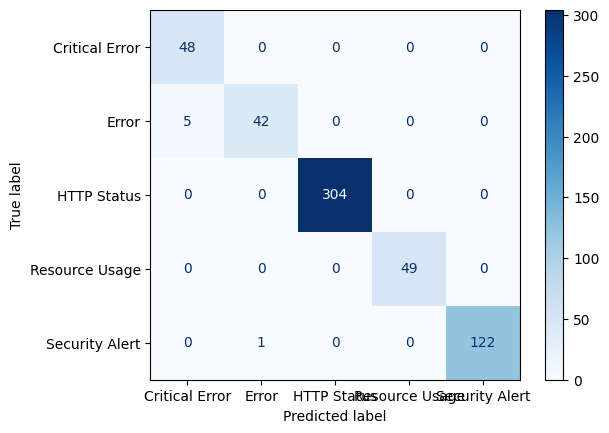

In [105]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_lr)

# Print the confusion matrix
print("Confusion Matrix:")
#print(conf_matrix)

# Optionally, display the confusion matrix as a plot
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=lr_model.classes_)
disp.plot(cmap='Blues')
plt.show()

In [107]:
import joblib
joblib.dump(lr_model, 'models/lr_model.joblib')
joblib.dump(rf_model, 'models/rf_model.joblib')
joblib.dump(svc_model, 'models/svc_model.joblib')

['models/svc_model.joblib']